# 宿泊施設のデータの取得

In [1]:
import sqlite3
import requests
from bs4 import BeautifulSoup
import time
import math
import re

##### 調べたい都道府県を入れておく

In [2]:
pref = ['saitama', 'kyoto']

##### データベースとテーブルの作成

In [3]:
# 取得したリポジトリを保存するデータベースのテーブルを作成
path = ''
db_name = 'rakuten-travel_hotels.db'

try:
    # DB接続オブジェクトの作成
    conn = sqlite3.connect(path + db_name)

    # SQL(RUBを操作するための言語)を実行するためのカーソルオブジェクトを取得
    cur = conn.cursor()

    # SQL文の作成
    # テーブルの作成
    sql = 'CREATE TABLE IF NOT EXISTS hotels (id INTEGER PRIMARY KEY AUTOINCREMENT, prefecture TEXT, name TEXT, rating REAL, review_count INTEGER, price INTEGER, has_bath INTEGER, has_onsen INTEGER, has_roten INTEGER, has_parking INTEGER, near_5min INTEGER, near_10min INTEGER, near_20min INTEGER, access TEXT);'
    # SQL文の実行
    cur.execute(sql)

except sqlite3.Error as e:
    print('エラーが発生しました：', e)

finally:
    # DBへの接続を閉じる
    conn.close()

##### スクレイピングのコード

In [5]:
path = ''
db_name = 'rakuten-travel_hotels.db'

total = 0

for p in pref:
    time.sleep(1.5)  # サーバーへの負荷を避けるために待機時間を入れる
    print(f"\n=== {p} のホテル情報を取得中 ===\n")
    # 1. 取得したいURL
    url = f"https://search.travel.rakuten.co.jp/ds/vacant/searchVacant?f_cd=02&f_dai=japan&f_chu={p}&f_nen1=2026&f_tuki1=02&f_hi1=03&f_nen2=2026&f_tuki2=02&f_hi2=04&f_otona_su=1&f_s1=0&f_s2=0&f_y1=0&f_y2=0&f_y3=0&f_y4=0&f_heya_su=1&f_kin2=0&f_ido=0.0&f_kdo=0.0&f_teikei=quick&f_sort=hotel_hotel_eval&f_page=1&f_hyoji=30&f_image=1&f_tab=hotel&f_latitude=0.0&f_longitude=0.0&f_point_min=0"
    # 2. サイトへの「お手紙」の設定（これがないと拒否されることがあります）
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
    }
    try:
        # 3. ページの中身を取得
        response = requests.get(url, headers=headers)
        # ステータスコードが200以外の場合に例外を発生させる
        response.raise_for_status()
        print("ステータスコード:", response.status_code)
        print("-----")
        response.encoding = response.apparent_encoding # 文字化け防止
        # 4. BeautifulSoupで解析
        soup = BeautifulSoup(response.text, "html.parser")
        # 全体件数を取得
        total_hit_tag = soup.find("span", class_="pagination__info-text--total")
        if total_hit_tag:
            total_hits = int(total_hit_tag.get_text())
            last_page = math.ceil(total_hits / 30) # 30件で割ってページ数を計算
            print(f"{p}の合計宿数: {total_hits}件 ({last_page}ページ分)")
        else:
            last_page = 1
    except Exception as e:
        print(f"件数取得エラー: {e}")
        last_page = 1

    # 2. ページ分だけループ
    for page in range(1, last_page + 1):
        print(f"--- {p}: {page} / {last_page} ページ目を処理中 ---")
        time.sleep(1.5)  # サーバーへの負荷を避けるために待機時間を入れる。
        url = f"https://search.travel.rakuten.co.jp/ds/vacant/searchVacant?f_longitude=0.0&f_image=1&f_ido=0.0&f_sort_cate=hotel&f_kdo=0.0&f_chu={p}&f_tuki1=02&f_sort=hotel_hotel_eval&f_tuki2=02&f_point_min=0&f_hi2=04&f_s2=0&f_s1=0&f_hi1=03&f_nen2=2026&f_nen1=2026&f_heya_su=1&f_kin2=0&f_teikei=quick&f_cd=02&f_latitude=0.0&f_tab=hotel&f_dai=japan&f_y4=0&f_y3=0&f_y2=0&f_otona_su=1&f_y1=0&f_hyoji=30&f_page={page}"
        
        response = requests.get(url, headers=headers)
        response.encoding = response.apparent_encoding
        soup = BeautifulSoup(response.text, "html.parser")

        # ホテルのカード枠を取得
        hotel_cards = soup.find_all("li", class_="htl-list-card")
        hotel_data_list = []

        print(f"{len(hotel_cards)} 件のホテルが見つかりました\n")

        for card in hotel_cards:
            time.sleep(0.5) # 負荷軽減
            try:
                # 基本情報
                name = card.find("h2", class_="hotel-list__title-text").get_text(strip=True)

                # 評価点数の取得
                rating_tag = card.select_one("p.cstmrEvl strong")
                rating = rating_tag.get_text(strip=True) if rating_tag else "0"
                
                # 口コミ件数の取得
                review_link = card.select_one("a[href*='review']") 
                if review_link:
                    # リンク内の全テキストを取得（例：「4.83(58件)」）
                    review_text = review_link.get_text(strip=True).replace(",", "")
                    
                    # 正規表現を修正：カッコの中にある数字だけを抜き出す
                    # \( は実際のカッコ、(\d+) は保存したい数字、\) は閉じカッコを意味します
                    rev_match = re.search(r'\((\d+)件?\)', review_text)
                    
                    if rev_match:
                        review_count = rev_match.group(1)  # カッコ内の数字を取得
                    else:
                        # カッコがない場合、点数を除去して残った数字を探す
                        # 点数（例: 4.83）を空白に置換してから数字を探す
                        clean_text = review_text.replace(rating, "")
                        second_match = re.search(r'(\d+)', clean_text)
                        review_count = second_match.group(1) if second_match else "0"
                else:
                    review_count = "0"

                # 価格
                price_input = card.find("input", id=lambda x: x and x.startswith("total-"))
                price = price_input['value'] if price_input and price_input.has_attr('value') else "0"

                # --- 特徴フラグの取得 ---
                feature_area = card.find("div", class_="hotelInfo_features")
                feature_text = ""
                if feature_area:
                    # すべての label タグからテキストを結合する
                    labels = feature_area.find_all("label")
                    feature_text = "".join([l.get_text() for l in labels])
                # キーワードが含まれているか判定
                has_bath = 1 if "大浴場" in feature_text else 0
                has_onsen = 1 if "温泉" in feature_text else 0
                has_roten = 1 if "露天風呂" in feature_text else 0
                has_parking = 1 if "駐車場" in feature_text else 0
                
                # アクセス情報から「駅徒歩○分以内」を判定
                # --- アクセス情報の解析ロジック ---
                access_text = card.find("p", class_="htlAccess").get_text() if card.find("p", class_="htlAccess") else ""
                # 正規表現で「徒歩」と「分」に挟まれた数字を探す
                # 例：「徒歩約○分」「徒歩にて○分」「徒歩○分」の全てから数字だけ抜く
                walk_time_match = re.search(r'徒歩.*?(\d+)分', access_text)
                # フラグの初期化
                near_5 = 0
                near_10 = 0
                near_20 = 0
                if walk_time_match:
                    minutes = int(walk_time_match.group(1))
                    # 条件分岐でフラグを立てる（重複して1を立てる設定にしています）
                    if minutes <= 5:
                        near_5 = 1
                    if minutes <= 10:
                        near_10 = 1
                    if minutes <= 20:
                        near_20 = 1

                # DB保存 (テーブル構造を自動で調整)
                # --- DB保存 (テーブル構造を修正) ---
                conn = sqlite3.connect(path + db_name)
                cur = conn.cursor()
                sql = """
                    INSERT INTO hotels
                    (prefecture, name, rating, review_count, price, has_bath, has_onsen, has_roten, has_parking, near_5min, near_10min, near_20min, access) 
                    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);
                """
                cur.execute(sql, (p, name, rating, review_count, price, has_bath, has_onsen, has_roten, has_parking, near_5, near_10, near_20, access_text))
                conn.commit()
                conn.close()
                
                total += 1
                # 途中経過の表示
                print(f"取得: {name[:10]}... | 評:{rating} | 口コミ:{review_count} | 温泉:{has_bath}/{has_onsen}/{has_roten} | 駐車場:{has_parking} | 駅近:{near_5}/{near_10}/{near_20} | 価格:{price}")
                print(f"現在までの取得件数：{total} 件")
                print("-----")

            except Exception as e:
                print(f"エラー発生（{name}）: {e}")
                continue

print("\n--- 【{p}のホテルの情報取得終了】  ---")

print("==== 全ページ取得完了 ====")
print(f"総件数：{total} 件")


=== saitama のホテル情報を取得中 ===

ステータスコード: 200
-----
saitamaの合計宿数: 239件 (8ページ分)
--- saitama: 1 / 8 ページ目を処理中 ---
30 件のホテルが見つかりました

取得: 女性のＯａｓｉｓ　パ... | 評:4.83 | 口コミ:58 | 温泉:1/0/0 | 駐車場:1 | 駅近:0/0/0 | 価格:6600
現在までの取得件数：1 件
-----
取得: 名栗温泉　大松閣... | 評:4.79 | 口コミ:375 | 温泉:1/0/1 | 駐車場:1 | 駅近:0/0/0 | 価格:23100
現在までの取得件数：2 件
-----
取得: ＷＡＬＬＡＢＹ　ＨＯ... | 評:4.70 | 口コミ:236 | 温泉:0/0/0 | 駐車場:0 | 駅近:0/1/1 | 価格:8000
現在までの取得件数：3 件
-----
取得: 旅館　きん藤... | 評:4.69 | 口コミ:271 | 温泉:1/0/0 | 駐車場:1 | 駅近:0/1/1 | 価格:6400
現在までの取得件数：4 件
-----
取得: 秩父長瀞温泉　大人の... | 評:4.67 | 口コミ:326 | 温泉:1/0/0 | 駐車場:1 | 駅近:0/1/1 | 価格:24000
現在までの取得件数：5 件
-----
取得: ビジネスホテル　豊泉... | 評:4.67 | 口コミ:380 | 温泉:0/0/0 | 駐車場:1 | 駅近:1/1/1 | 価格:8075
現在までの取得件数：6 件
-----
取得: レクトーレ羽生ＴＥＲ... | 評:4.67 | 口コミ:51 | 温泉:0/0/0 | 駐車場:0 | 駅近:0/0/0 | 価格:7700
現在までの取得件数：7 件
-----
取得: ホテルメトロポリタン... | 評:4.65 | 口コミ:1230 | 温泉:0/0/0 | 駐車場:0 | 駅近:1/1/1 | 価格:12500
現在までの取得件数：8 件
-----
取得: クラッシック＆モダン... | 評:4.65 | 口コミ:56 | 温泉:0/0/0 | 駐車場:1 | 駅近:1/1/1 | 価格:16500
現在までの取得件数：9 件
-----
取得: レ

##### データベースに保存したデータを表示

In [8]:
# データベースに保存したデータをSELECT文を用いて表示
path = ''
db_name = 'rakuten-travel_hotels.db'

try:
    # DB接続オブジェクトの作成
    conn = sqlite3.connect(path + db_name)

    # SQL(RUBを操作するための言語)を実行するためのカーソルp武ジェクトを取得
    cur = conn.cursor()

    # SQL文の作成
    # SELECT * FROM テーブル名;
    # *　の部分は取得したい列の名前を区切りで指定することができる
    sql = "SELECT * FROM hotels;"

    # SQL文の実行
    cur.execute(sql)
    
except sqlite3.Error as e:
    print('エラーが発生しました：', e)

else:
    for row in cur:
        # 行データ(row)はタプルなので、アンバックして列データを取得
        id, prefecture, name, rating, review_count, price, has_bath, has_onsen, has_roten, has_parking, near_5min, near_10min, near_20min, access = row
        print(row)

finally:
    # DBへの接続を閉じる
    conn.close()

(1, 'saitama', '女性のＯａｓｉｓ\u3000パルムリゾート秩父', 4.83, 58, 6600, 1, 0, 0, 1, 0, 0, 0, '\nアクセス\u3000：西武秩父駅よりお車にて約１５分\n地図から探す\n')
(2, 'saitama', '名栗温泉\u3000大松閣', 4.79, 375, 23100, 1, 0, 1, 1, 0, 0, 0, '\nアクセス\u3000：飯能駅より路線バスで45分・車で30分/飯能駅南口より送迎バス有 10:30・11:45・15:00・16:30要予約\n地図から探す\n')
(3, 'saitama', 'ＷＡＬＬＡＢＹ\u3000ＨＯＵＳＥ', 4.7, 236, 8000, 0, 0, 0, 0, 0, 1, 1, '\nアクセス\u3000：JR京浜東北線\u3000蕨駅東口より徒歩約８分。\u3000お車の場合：東京外環自動車道\u3000川口西ICより２km\u3000※駐車場はございません\n地図から探す\n')
(4, 'saitama', '旅館\u3000きん藤', 4.69, 271, 6400, 1, 0, 0, 1, 0, 1, 1, '\nアクセス\u3000：深谷駅北側徒歩７分、旧中山道沿い、花園ＩＣより【２５分】１０ｋｍ\n地図から探す\n')
(5, 'saitama', '秩父長瀞温泉\u3000大人の隠れ癒し宿\u3000花湯別邸', 4.67, 326, 24000, 1, 0, 0, 1, 0, 1, 1, '\nアクセス\u3000：秩父鉄道≪野上駅≫より徒歩にて約10分\n地図から探す\n')
(6, 'saitama', 'ビジネスホテル\u3000豊泉閣', 4.67, 380, 8075, 0, 0, 0, 1, 1, 1, 1, '\nアクセス\u3000：ＪＲ浦和駅東口徒歩3分♪パルコ1分、伊勢丹5分、大宮駅電車で10分、スーパーアリーナにも便利、赤羽まで電車で8分！\n地図から探す\n')
(7, 'saitama', 'レクトーレ羽生ＴＥＲＲＡＣＥ（ＴＫＰ\u3000Ｈｏｔｅｌｓ\u3000＆\u3000Ｒｅｓｏｒｔｓ）', 4.67, 51, 7700, 0, 0, 0, 0, 0, 0, 0, '\nアクセス\u3000：東武伊勢

# データベースに格納されたデータを用いた分析

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 日本語フォントの設定
plt.rcParams['font.family'] = 'Hiragino Sans'
plt.rcParams['axes.unicode_minus'] = False

##### 記述統計：まずは全体の把握

In [68]:
path = ''
db_name = 'rakuten-travel_hotels.db'

try:
    # 1. DB接続オブジェクトの作成
    conn = sqlite3.connect(path + db_name)
    
    # 2. SQL文の作成
    sql = "SELECT * FROM hotels;"
    
    # 3. Pandasを使って一括でDataFrameに読み込む
    df = pd.read_sql(sql, conn)
    
    # 読み込み成功の確認（最初の5件を表示）
    print("データの読み込みに成功しました。")
    print(df.head())

except sqlite3.Error as e:
    print('データベースエラーが発生しました：', e)

except Exception as e:
    print('予期せぬエラーが発生しました：', e)

finally:
    # 4. DBへの接続を確実に閉じる
    conn.close()

# これで変数 'df' を使って、次の「分析・可視化」へ進めます！

データの読み込みに成功しました。
   id prefecture                  name  rating  review_count  price  has_bath  \
0   1    saitama    女性のＯａｓｉｓ　パルムリゾート秩父    4.83            58   6600         1   
1   2    saitama              名栗温泉　大松閣    4.79           375  23100         1   
2   3    saitama         ＷＡＬＬＡＢＹ　ＨＯＵＳＥ    4.70           236   8000         0   
3   4    saitama                旅館　きん藤    4.69           271   6400         1   
4   5    saitama  秩父長瀞温泉　大人の隠れ癒し宿　花湯別邸    4.67           326  24000         1   

   has_onsen  has_roten  has_parking  near_5min  near_10min  near_20min  \
0          0          0            1          0           0           0   
1          0          1            1          0           0           0   
2          0          0            0          0           1           1   
3          0          0            1          0           1           1   
4          0          0            1          0           1           1   

                                             

In [80]:
class HotelAnalyzer:
    def __init__(self, db_path):
        # データベースからデータを読み込み、初期設定を行う
        self.db_path = db_path
        self.df = self._load_data()

    def _load_data(self):
        # 内部でDBからクエリを発行してデータを取得する（要件対応）
        try:
            conn = sqlite3.connect(self.db_path)
            sql = "SELECT * FROM hotels;"
            df = pd.read_sql(sql, conn)
            # ここでデータ型を数値に変換するなどの前処理を行う
            # 例: df['price'] = pd.to_numeric(df['price'], errors='coerce')
            return df
        except Exception as e:
            print(f"データ読み込みエラー: {e}")
        finally:
            conn.close()

    def analyze_area(self, area_name):
        # 入力されたエリアに応じて、価格と評価の相関を可視化する（動的変化）
        # 入力に基づいてデータをフィルタリング
        target_df = self.df[self.df['prefecture'] == area_name]
        
        if target_df.empty:
            print(f"エリア '{area_name}' のデータが見つかりません。")
            return

        print(f"--- {area_name} エリアの分析結果 ---")
        print(target_df[['price', 'rating']].describe()) # 基本統計量

        # 可視化
        plt.figure(figsize=(10, 5))
        sns.scatterplot(data=target_df, x='price', y='rating', hue='rating', palette='viridis')
        plt.title(f'金額と評価についての散布図 in {area_name}')
        plt.xlabel('金額 (円)')
        plt.ylabel('評価')
        plt.grid(True)
        plt.show()

    def analyze_features(self, area_name):
        # 指定したエリアの設備（温泉・露天風呂）の有無による評価の差を可視化する
        # 指定されたエリアで絞り込み
        target_df = self.df[self.df['prefecture'] == area_name].copy()
        
        if target_df.empty:
            print(f"エリア '{area_name}' のデータが見つかりません。")
            return

        plt.figure(figsize=(12, 5))

        # 1. 温泉の有無での比較
        plt.subplot(1, 2, 1)
        sns.boxplot(data=target_df, x='has_onsen', y='rating', palette='Pastel1')
        plt.title(f'温泉の設置状態と評価の関係を表した箱ひげ図 in {area_name}')
        plt.xlabel('0: No / 1: Yes')
        plt.ylabel('評価')

        # 2. 露天風呂の有無での比較
        plt.subplot(1, 2, 2)
        sns.boxplot(data=target_df, x='has_roten', y='rating', palette='Pastel2')
        plt.title(f'露天風呂の設置状態と評価の関係を表した箱ひげ図 in {area_name}')
        plt.xlabel('0: No / 1: Yes')
        plt.ylabel('評価')

        plt.tight_layout()
        plt.show()

    def analyze_access_impact(self, area_name):
        # 指定したエリアの立地（駅からの距離）が評価に与える影響を分析する
        # 指定されたエリアで絞り込み
        target_df = self.df[self.df['prefecture'] == area_name].copy()
        
        if target_df.empty:
            print(f"エリア '{area_name}' のデータが見つかりません。")
            return

        # アクセスグループのラベル付け
        def label_access(row):
            if row['near_5min'] == 1: return '5分以内'
            if row['near_10min'] == 1: return '10分以内'
            if row['near_20min'] == 1: return '20分以内'
            return '20分超'

        target_df['access_group'] = target_df.apply(label_access, axis=1)
        order = ['5分以内', '10分以内', '20分以内', '20分超']

        plt.figure(figsize=(10, 6))
        sns.boxplot(data=target_df, x='access_group', y='rating', order=order, palette='Set3')
        plt.title(f'立地(駅からの徒歩時間)と評価の関係を表した箱ひげ図 in {area_name}')
        plt.xlabel('駅からの徒歩時間')
        plt.ylabel('評価')
        plt.show()

    def analyze_review_reliability(self, area_name):
        # 指定したエリアの口コミ数と評価の相関を分析する
        # 指定されたエリアで絞り込み
        target_df = self.df[self.df['prefecture'] == area_name].copy()
        
        # 数値型に変換
        target_df['review_count'] = pd.to_numeric(target_df['review_count'], errors='coerce')
        target_df = target_df.dropna(subset=['review_count', 'rating'])

        if target_df.empty:
            print(f"エリア '{area_name}' のデータが見つかりません。")
            return

        plt.figure(figsize=(10, 6))
        sns.regplot(data=target_df, x='review_count', y='rating', 
                    scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
        plt.title(f'口コミ数と評価の関係を表した散布図 in {area_name}')
        plt.xlabel('口コミ数')
        plt.ylabel('評価')
        plt.show()
        
    def analyze_correlation_heatmap(self, area_name):
        # 指定したエリアの各要素間の相関関係をヒートマップで可視化する
        target_df = self.df[self.df['prefecture'] == area_name].copy()
        
        if target_df.empty:
            print(f"エリア '{area_name}' のデータが見つかりません。")
            return

        # 相関を見たい数値カラムを選択
        cols = ['rating', 'price', 'review_count', 'has_onsen', 'has_roten', 'near_5min']
        
        # 数値型に変換
        for col in cols:
            target_df[col] = pd.to_numeric(target_df[col], errors='coerce')
        
        # 相関行列の作成
        corr = target_df[cols].corr()

        # ヒートマップの描画
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, center=0)
        plt.title(f'評価と施設の特徴との関係を表すヒートマップ in {area_name}')
        plt.show()

# --- 実行セクション ---
# クラスのインスタンス化
analyzer = HotelAnalyzer('rakuten-travel_hotels.db')

--- saitama エリアの分析結果 ---
               price      rating
count     478.000000  478.000000
mean    12118.104603    3.640209
std     14827.818093    1.359346
min      3000.000000    0.000000
25%      6900.000000    3.730000
50%      8120.000000    4.070000
75%     10700.000000    4.365000
max    145580.000000    5.000000


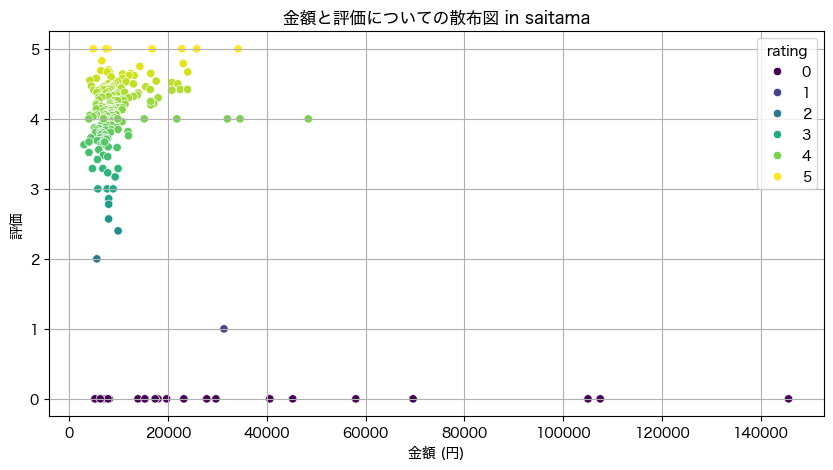

In [81]:
analyzer.analyze_area('saitama')

--- kyoto エリアの分析結果 ---
               price       rating
count    2064.000000  2064.000000
mean    22539.254845     3.008634
std     25284.188917     1.985778
min      1600.000000     0.000000
25%      7700.000000     0.000000
50%     13000.000000     4.000000
75%     28000.000000     4.500000
max    238680.000000     5.000000


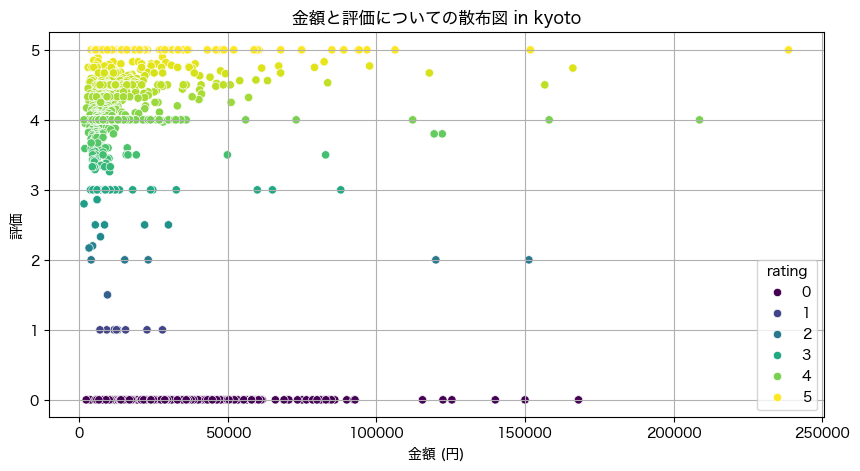

In [82]:
analyzer.analyze_area('kyoto')

/var/folders/zf/8lsx711s4g127_fk_fcn4shw0000gn/T/ipykernel_47806/563776572.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=target_df, x='has_onsen', y='rating', palette='Pastel1')
/var/folders/zf/8lsx711s4g127_fk_fcn4shw0000gn/T/ipykernel_47806/563776572.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=target_df, x='has_roten', y='rating', palette='Pastel2')


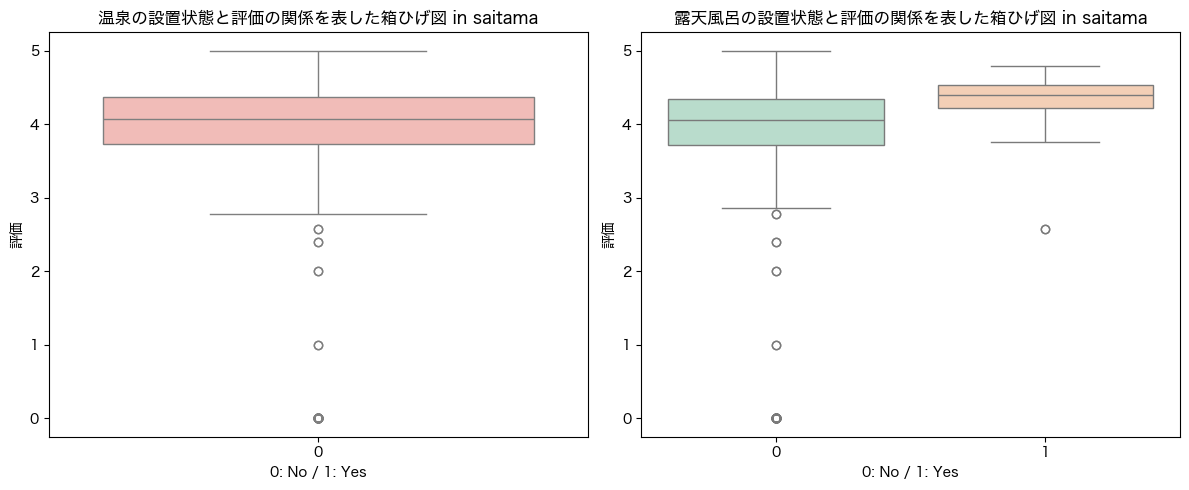

In [83]:
analyzer.analyze_features('saitama')

/var/folders/zf/8lsx711s4g127_fk_fcn4shw0000gn/T/ipykernel_47806/563776572.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=target_df, x='has_onsen', y='rating', palette='Pastel1')
/var/folders/zf/8lsx711s4g127_fk_fcn4shw0000gn/T/ipykernel_47806/563776572.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=target_df, x='has_roten', y='rating', palette='Pastel2')


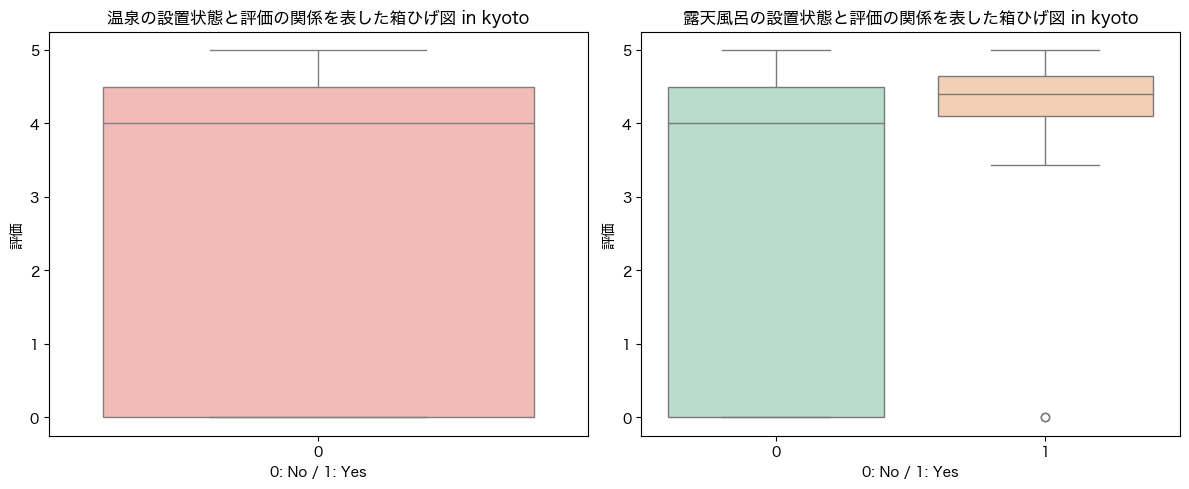

In [84]:
analyzer.analyze_features('kyoto')

/var/folders/zf/8lsx711s4g127_fk_fcn4shw0000gn/T/ipykernel_47806/563776572.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=target_df, x='access_group', y='rating', order=order, palette='Set3')


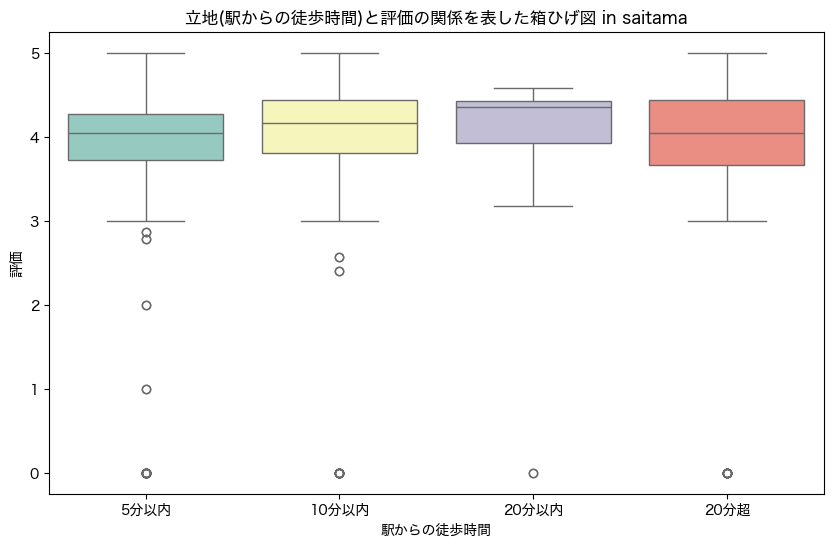

In [85]:
analyzer.analyze_access_impact('saitama')

/var/folders/zf/8lsx711s4g127_fk_fcn4shw0000gn/T/ipykernel_47806/563776572.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=target_df, x='access_group', y='rating', order=order, palette='Set3')


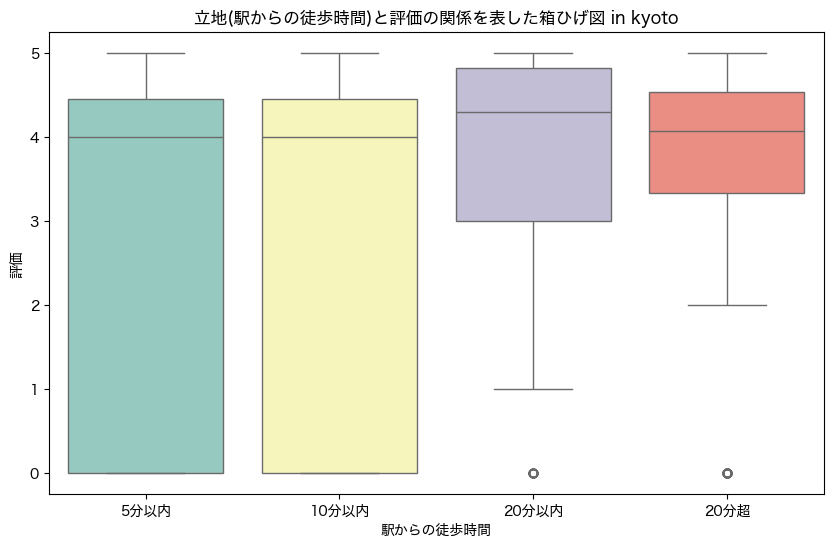

In [86]:
analyzer.analyze_access_impact('kyoto')

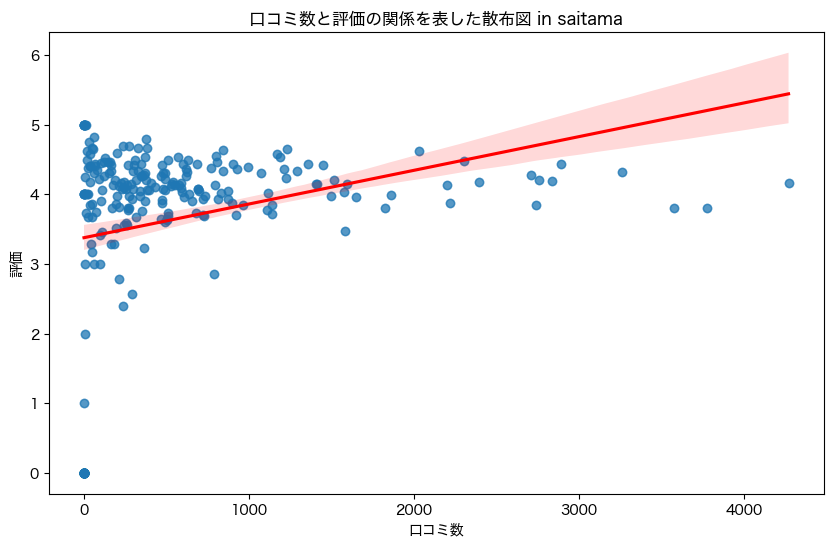

In [87]:
analyzer.analyze_review_reliability('saitama')

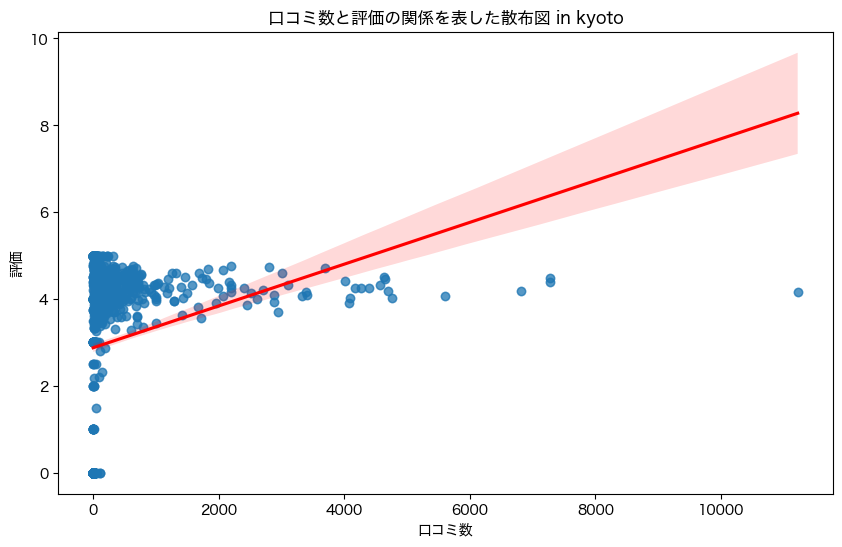

In [88]:
analyzer.analyze_review_reliability('kyoto')

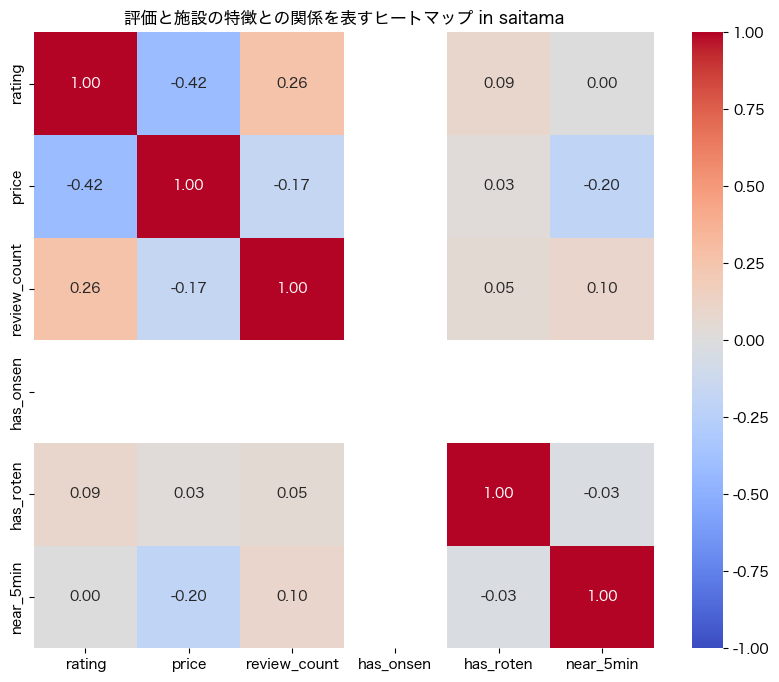

In [89]:
analyzer.analyze_correlation_heatmap('saitama')

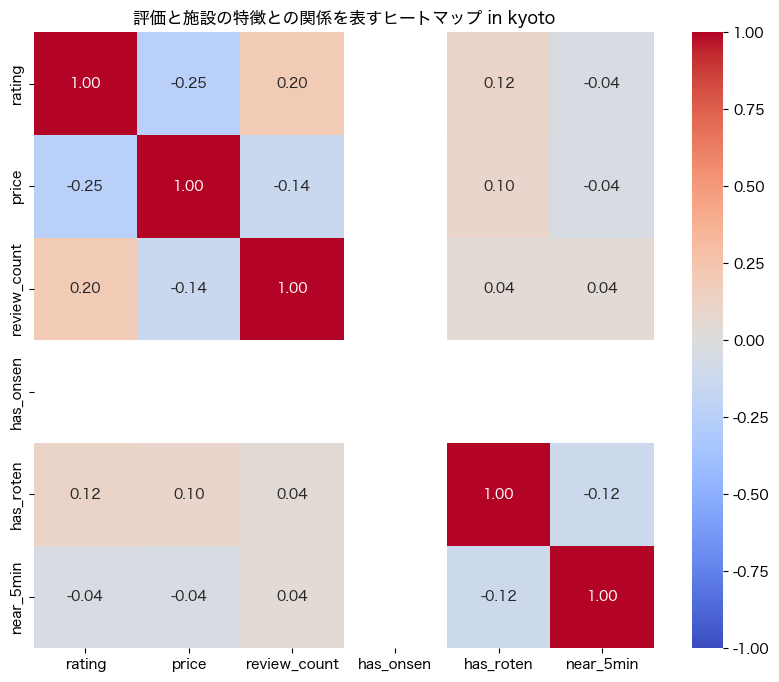

In [90]:
analyzer.analyze_correlation_heatmap('kyoto')